# Document loaders  文档加载器
- 文档加载器负责从各种来源加载文档。
- 常见的有PDF/网页/csv数据/从目录中/HTML数据/JSON数据/Markdown数据/Microsoft Office 数据等

## 准备数据

### chat models

In [1]:
import sys
sys.path.append('/Users/ericyoung/ysx/code/github-study/langChain-rookie')
from env_utils import load_environment_variables

load_environment_variables()

__file__: /Users/ericyoung/ysx/code/github-study/langChain-rookie/env_utils.py
dotenv_path1: /Users/ericyoung/ysx/code/github-study/langChain-rookie/.env
load env ok


#### 支持tool的 chat model

In [2]:
# Ollama
from langchain_ollama import ChatOllama
# llm = ChatOllama(
#     model="qwen2.5:latest", # gemma3:latest(不支持tool)
#     temperature=0.7,
#     # other params...
# )

#### 不支持tool的chat model

In [3]:
# 任何chat model
# from models import MyOpenAIModel
#
# model = MyOpenAIModel()
# response = model.generate("你好，介绍一下你自己")
# print(response)

#### ⭐️ 不支持tool模型 利用 ChatOpenAI (使用base_url) 实现 bind_tools
- 支持结构化输出, with_structured_output方法
- 支持使用工具, bind_tools方法
- llm = ChatOpenAI(
                model="gpt-4o",
                temperature=0,
                max_tokens=None,
                timeout=None,
                max_retries=2,
                # api_key="...",
                # base_url="...",
                # organization="...",
                # other params...
            )

In [4]:
from models import get_base_url_model_with_tools
llm = get_base_url_model_with_tools()
print(llm.invoke("你是谁?").content)



您好！我是由中国的深度求索（DeepSeek）公司开发的智能助手DeepSeek-R1。如您有任何任何问题，我会尽我所能为您提供帮助。


 ### embedding模型

In [5]:
from embeddings import LMStudioEmbeddings
from vector_similarity import *
embedding_model = LMStudioEmbeddings()
a = embedding_model.embed_documents("你好")[0]
b = embedding_model.embed_query("你好啊")
print("余弦相似度 (自定义):", cosine_similarity_custom(a, b))

余弦相似度 (自定义): 0.9786437338604382


## How to load PDFs

### Simple and fast text extraction 简单快速文本提取
- LangChain 文档加载器实现了 lazy_load 及其异步变体 alazy_load ，它们返回 Document 对象的迭代器。
- 底层，它使用 pypdf Python 库。

In [6]:
# %pip install -qU pypdf

In [7]:
file_path = (
    "../example_data/layout-parser-paper.pdf"
)

In [8]:
from langchain_community.document_loaders import PyPDFLoader

loader = PyPDFLoader(file_path)
pages = []
async for page in loader.alazy_load():
    pages.append(page)

print(f"{pages[0].metadata}\n")
print(pages[0].page_content)

{'producer': 'pdfTeX-1.40.21', 'creator': 'LaTeX with hyperref', 'creationdate': '2021-06-22T01:27:10+00:00', 'author': '', 'keywords': '', 'moddate': '2021-06-22T01:27:10+00:00', 'ptex.fullbanner': 'This is pdfTeX, Version 3.14159265-2.6-1.40.21 (TeX Live 2020) kpathsea version 6.3.2', 'subject': '', 'title': '', 'trapped': '/False', 'source': '../example_data/layout-parser-paper.pdf', 'total_pages': 16, 'page': 0, 'page_label': '1'}

LayoutParser: A Uniﬁed Toolkit for Deep
Learning Based Document Image Analysis
Zejiang Shen1 (  ), Ruochen Zhang2, Melissa Dell3, Benjamin Charles Germain
Lee4, Jacob Carlson3, and Weining Li5
1 Allen Institute for AI
shannons@allenai.org
2 Brown University
ruochen zhang@brown.edu
3 Harvard University
{melissadell,jacob carlson}@fas.harvard.edu
4 University of Washington
bcgl@cs.washington.edu
5 University of Waterloo
w422li@uwaterloo.ca
Abstract. Recent advances in document image analysis (DIA) have been
primarily driven by the application of neural net

### Vector search over PDFs  向量搜索在 PDF 文件中
- 将 PDF 文件加载到 LangChain Document 对象中，我们就可以以常规方式对其进行索引（例如，一个 RAG 应用）。
- 任何 LangChain 嵌入模型都足够。

In [9]:
from langchain_core.vectorstores import InMemoryVectorStore
# from langchain_openai import OpenAIEmbeddings

vector_store = InMemoryVectorStore.from_documents(pages, embedding_model)
docs = vector_store.similarity_search("What is LayoutParser?", k=2)
for doc in docs:
    print(f'Page {doc.metadata["page"]}: {doc.page_content[:300]}\n')

Page 6: LayoutParser: A Uniﬁed Toolkit for DL-Based DIA 7
Coordinates are the cornerstones for storing layout information. Currently,
three types of Coordinate data structures are provided in LayoutParser, shown
in Figure 2. Interval and Rectangle are the most common data types and
support specifying 1D or 

Page 13: 14 Z. Shen et al.
6 Conclusion
LayoutParser provides a comprehensive toolkit for deep learning-based document
image analysis. The oﬀ-the-shelf library is easy to install, and can be used to
build ﬂexible and accurate pipelines for processing documents with complicated
structures. It also supports hi



### Layout analysis and extraction of text from images 图像布局分析与文本提取
- 更细粒度的文本分割（例如，到不同的段落、标题、表格或其他结构）或需要从图像中提取文本，以下方法适用。
- 它将返回一个文档对象列表，其中每个对象代表页面上的一个结构。
- 文档的元数据存储页面编号以及其他与对象相关的信息（例如，在表格对象的情况下，可能存储表格的行和列）
- 底层使用 [langchain-unstructured 库](https://docs.unstructured.io/welcome)
- 非结构化支持多个参数进行 PDF 解析：
    - strategy (e.g., "fast" or "hi-res"[高分辨率策略]),高分辨率策略提供对文档布局分析和 OCR 的支持。
    - API 需要 API 密钥。 或[本地处理](https://python.langchain.com/docs/how_to/document_loader_pdf/#local-parsing)。

#### API
- %pip install -qU "unstructured[pdf]"

In [10]:
# 本地处理
# %pip install -qU "unstructured[pdf]"
# %pip install langchain-unstructured

In [11]:
# 初始化一个加载器并懒加载文档, 需要配置API,UNSTRUCTURED_API_KEY
from langchain_unstructured import UnstructuredLoader

loader = UnstructuredLoader(
    file_path=file_path,
    strategy="hi_res",
    partition_via_api=True,
    coordinates=True,
)
docs = []
for doc in loader.lazy_load():
    docs.append(doc)
print(len(docs)) # 在 16 页文档中恢复了 171 个不同的结构

INFO: Preparing to split document for partition.
INFO: Starting page number set to 1
INFO: Allow failed set to 0
INFO: Concurrency level set to 5
INFO: Splitting pages 1 to 16 (16 total)
INFO: Determined optimal split size of 4 pages.
INFO: Partitioning 4 files with 4 page(s) each.
INFO: Partitioning set #1 (pages 1-4).
INFO: Partitioning set #2 (pages 5-8).
INFO: Partitioning set #3 (pages 9-12).
INFO: Partitioning set #4 (pages 13-16).
INFO: Failed to process a request due to API server error with status code 502. Attempting retry number 1 after sleep.
INFO: Server message - <html>
<head><title>502 Bad Gateway</title></head>
<body>
<center><h1>502 Bad Gateway</h1></center>
</body>
</html>

ERROR: Failed to partition the document.
INFO: Preparing to split document for partition.
INFO: Starting page number set to 1
INFO: Allow failed set to 0
INFO: Concurrency level set to 5
INFO: Splitting pages 1 to 16 (16 total)
INFO: Determined optimal split size of 4 pages.
INFO: Partitioning 4 fi

ServerError: {"detail":"API key is malformed, please type the API key correctly in the header."}

- 以使用文档元数据从单页中恢复内容：

In [13]:
first_page_docs = [doc for doc in docs if doc.metadata.get("page_number") == 1]

for doc in first_page_docs:
    print(doc.page_content)

#### 本地处理
- 本地解析需要安装额外的依赖项。
- （PDF 分析）
    - Linux: apt-get install poppler-utils
    - Mac: brew install poppler
    - Windows: https://github.com/oschwartz10612/poppler-windows
- Tesseract（OCR）
    - Linux: apt-get install tesseract-ocr
    - Mac: brew install tesseract
    - Windows: https://github.com/UB-Mannheim/tesseract/wiki#tesseract-installer-for-windows

In [ ]:
# 速度很慢
loader_local = UnstructuredLoader(
    file_path=file_path,
    strategy="fast", # hi-res
)
docs_local = []
for doc in loader_local.lazy_load():
    docs_local.append(doc)

In [ ]:
print(len(docs_local))

In [ ]:
local_first_page_docs = [doc for doc in docs_local if doc.metadata.get("page_number") == 1]

for doc in local_first_page_docs:
    print(doc.page_content)

### Extracting tables and other structures 提取表格和其他结构
- 每次我们加载的 Document 都代表一个结构，如标题、段落或表格。
- 某些结构可能对索引或问答任务特别适合。这些结构可能包括：
    - Classified for easy identification;分类以便于识别；
    - Parsed into a more structured representation.解析为更结构化的表示。

#### 识别并提取了一个表格
- %pip install -qU matplotlib PyMuPDF pillow

In [14]:
# %pip install -qU matplotlib PyMuPDF pillow

In [15]:
import fitz
import matplotlib.patches as patches
import matplotlib.pyplot as plt
from PIL import Image


def plot_pdf_with_boxes(pdf_page, segments):
    pix = pdf_page.get_pixmap()
    pil_image = Image.frombytes("RGB", [pix.width, pix.height], pix.samples)

    fig, ax = plt.subplots(1, figsize=(10, 10))
    ax.imshow(pil_image)
    categories = set()
    category_to_color = {
        "Title": "orchid",
        "Image": "forestgreen",
        "Table": "tomato",
    }
    for segment in segments:
        points = segment["coordinates"]["points"]
        layout_width = segment["coordinates"]["layout_width"]
        layout_height = segment["coordinates"]["layout_height"]
        scaled_points = [
            (x * pix.width / layout_width, y * pix.height / layout_height)
            for x, y in points
        ]
        box_color = category_to_color.get(segment["category"], "deepskyblue")
        categories.add(segment["category"])
        rect = patches.Polygon(
            scaled_points, linewidth=1, edgecolor=box_color, facecolor="none"
        )
        ax.add_patch(rect)

    # Make legend
    legend_handles = [patches.Patch(color="deepskyblue", label="Text")]
    for category in ["Title", "Image", "Table"]:
        if category in categories:
            legend_handles.append(
                patches.Patch(color=category_to_color[category], label=category)
            )
    ax.axis("off")
    ax.legend(handles=legend_handles, loc="upper right")
    plt.tight_layout()
    plt.show()


def render_page(doc_list: list, page_number: int, print_text=True) -> None:
    pdf_page = fitz.open(file_path).load_page(page_number - 1)
    page_docs = [
        doc for doc in doc_list if doc.metadata.get("page_number") == page_number
    ]
    segments = [doc.metadata for doc in page_docs]
    plot_pdf_with_boxes(pdf_page, segments)
    if print_text:
        for doc in page_docs:
            print(f"{doc.page_content}\n")

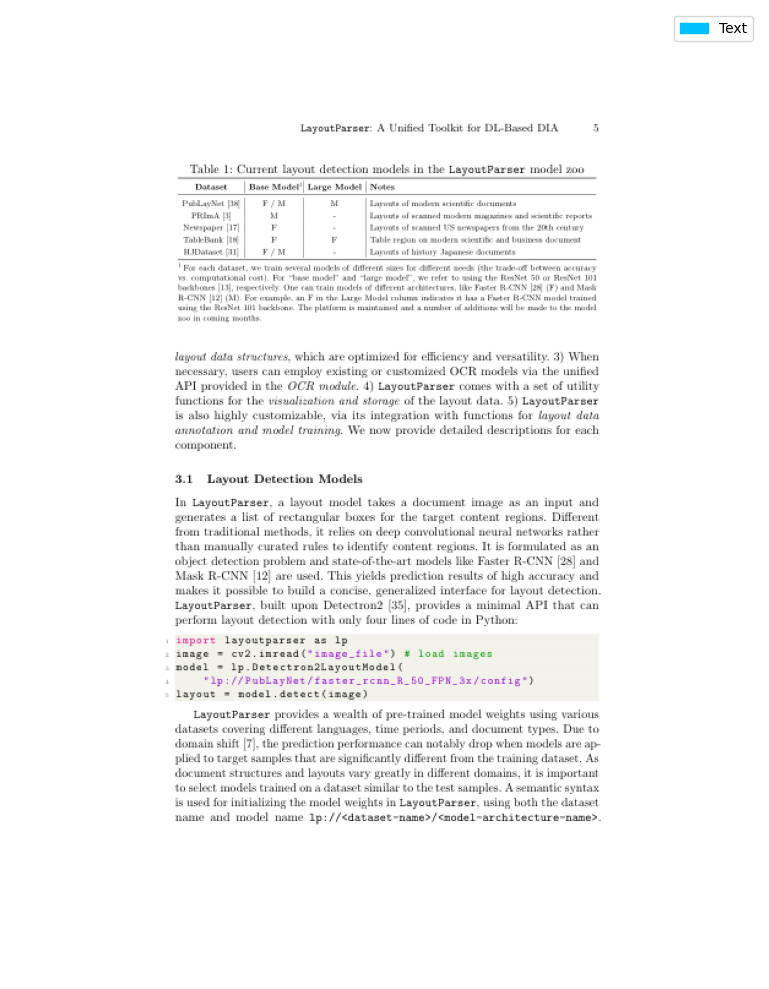

In [16]:
render_page(docs_local, 5)

- 请注意，尽管表格文本在文档内容中被折叠成一个单独的字符串，但元数据包含其行和列的表示：

In [17]:
from IPython.display import HTML, display

segments = [
    doc.metadata
    for doc in docs_local
    if doc.metadata.get("page_number") == 5 and doc.metadata.get("category") == "Table"
]

display(HTML(segments[0]["text_as_html"]))

IndexError: list index out of range

- 提取与文档“结论”部分相关的所有文本：

In [ ]:
render_page(docs_local, 14, print_text=False)

In [ ]:
conclusion_docs = []
parent_id = -1
for doc in docs_local:
    if doc.metadata["category"] == "Title" and "Conclusion" in doc.page_content:
        parent_id = doc.metadata["element_id"]
    if doc.metadata.get("parent_id") == parent_id:
        conclusion_docs.append(doc)

for doc in conclusion_docs:
    print(doc.page_content)

### Extracting text from images - 从图像中提取文本
- OCR 在图像上运行，从而实现其中文本的提取：

In [ ]:
render_page(docs_local, 11)

### Use of multimodal models  多模态模型的使用
- 许多LLMs支持对多模态输入进行推理（例如图像）。
- 在某些应用中——例如对具有复杂布局、图表或扫描的 PDF 进行问答——跳过 PDF 解析可能更有利，而是将 PDF 页面转换为图像并直接传递给模型。
- 这允许模型对页面上的二维内容进行推理，而不是“一维”的字符串表示。

In [ ]:
# %pip install -qU PyMuPDF pillow

#### PDF转换为图片

In [ ]:
import base64
import io

import fitz
from PIL import Image


def pdf_page_to_base64(pdf_path: str, page_number: int):
    pdf_document = fitz.open(pdf_path)
    page = pdf_document.load_page(page_number - 1)  # input is one-indexed
    pix = page.get_pixmap()
    img = Image.frombytes("RGB", [pix.width, pix.height], pix.samples)

    buffer = io.BytesIO()
    img.save(buffer, format="PNG")

    return base64.b64encode(buffer.getvalue()).decode("utf-8")

In [ ]:
from IPython.display import Image as IPImage
from IPython.display import display

base64_image = pdf_page_to_base64(file_path, 11)
display(IPImage(data=base64.b64decode(base64_image)))

#### 使用多模态大模型进行提问

In [ ]:
from langchain_core.messages import HumanMessage
llm = get_base_url_model_with_tools(base_url="http://192.168.1.22:1234/v1", model="qwen2.5-vl-3b-instruct")
query = "What is the name of the first step in the pipeline?"

message = HumanMessage(
    content=[
        {"type": "text", "text": query},
        {
            "type": "image_url",
            "image_url": {"url": f"data:image/jpeg;base64,{base64_image}"},
        },
    ],
)
response = llm.invoke([message])
print(response.content)

### Other PDF loaders  其他 PDF 加载器
- [可用的 LangChain PDF 加载器列表](https://python.langchain.com/docs/integrations/document_loaders/#pdfs)